# Singel Molecule Event classification.

### Write details about the datset and motivation of this project

# Importing necessary libraries

In [800]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import multiprocessing

# models
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from catboost import CatBoostClassifier

from dask.distributed import Client
# It's recommended to use dask_cuda for GPU assignment
from dask_cuda import LocalCUDACluster
from dask import array as da
import xgboost as xgb
import dask
#import dask_xgboost
#import dask.distributed

# new utils
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler, SMOTE
# to visualize the column transformer and pipeline
set_config(display='diagram')

In [801]:
# Importing the data

In [802]:
df = pd.read_csv('C://Users//Asus//OneDrive//Desktop//Jayesh_ML//Single_Molecule_Event_Classification//Data_set/DataSet_Kan_100mV_set2.csv',low_memory=False )
df.head() 

,Trace,Search,Level,State,Event Start Time (ms),Event End Time (ms),Amplitude (pA),Amp S.D. (pA),Dwell Time (ms),Peak-to-Peak Frequency (Hz),Interevent Interval (ms)
0,1,1,1,AB,0.22,0.26,36.300587,0.000000,0.04,NaN,Not found
1,1,1,0,A,0.26,1.50,1.740591,5.838978,1.24,NaN,Not found
2,1,1,1,AB,1.50,1.56,9.592655,0.000000,0.06,781.250000,1.279999971
3,1,1,0,A,1.56,3.42,0.673338,6.202096,1.86,769.230774,1.299999952
4,1,1,1,AB,3.42,3.46,49.259743,0.000000,0.04,520.833313,1.919999957


# Data Wrangling and EDA

In [803]:
#quick way to check the datatypes and if the dataframe has any null val
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225830 entries, 0 to 225829
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Trace                        225830 non-null  int64  
 1   Search                       225830 non-null  int64  
 2   Level                        225830 non-null  int64  
 3   State                        225830 non-null  object 
 4   Event Start Time (ms)        225830 non-null  float64
 5   Event End Time (ms)          225830 non-null  float64
 6   Amplitude (pA)               225830 non-null  float64
 7   Amp S.D. (pA)                225830 non-null  float64
 8   Dwell Time (ms)              225830 non-null  float64
 9   Peak-to-Peak Frequency (Hz)  225825 non-null  float64
 10  Interevent Interval (ms)     225830 non-null  object 
dtypes: float64(6), int64(3), object(2)
memory usage: 19.0+ MB


In [804]:
# checking any null val in the dataframe
df.isna().sum()

Trace                          0
Search                         0
Level                          0
State                          0
Event Start Time (ms)          0
Event End Time (ms)            0
Amplitude (pA)                 0
Amp S.D. (pA)                  0
Dwell Time (ms)                0
Peak-to-Peak Frequency (Hz)    5
Interevent Interval (ms)       0
dtype: int64

In [805]:
# checking the shape/ size of a dataframe
df.shape

(225830, 11)

In [806]:
# Removing null vales from the dataset
df.dropna(subset = ["Peak-to-Peak Frequency (Hz)"], inplace=True)

# transforming the datatype from object to numeric
df['Interevent Interval (ms)'] = pd.to_numeric(df['Interevent Interval (ms)'])

In [807]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225825 entries, 2 to 225829
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Trace                        225825 non-null  int64  
 1   Search                       225825 non-null  int64  
 2   Level                        225825 non-null  int64  
 3   State                        225825 non-null  object 
 4   Event Start Time (ms)        225825 non-null  float64
 5   Event End Time (ms)          225825 non-null  float64
 6   Amplitude (pA)               225825 non-null  float64
 7   Amp S.D. (pA)                225825 non-null  float64
 8   Dwell Time (ms)              225825 non-null  float64
 9   Peak-to-Peak Frequency (Hz)  225825 non-null  float64
 10  Interevent Interval (ms)     225825 non-null  float64
dtypes: float64(7), int64(3), object(1)
memory usage: 20.7+ MB


In [808]:
df.head()

,Trace,Search,Level,State,Event Start Time (ms),Event End Time (ms),Amplitude (pA),Amp S.D. (pA),Dwell Time (ms),Peak-to-Peak Frequency (Hz),Interevent Interval (ms)
2,1,1,1,AB,1.50,1.56,9.592655,0.000000,0.06,781.250000,1.28
3,1,1,0,A,1.56,3.42,0.673338,6.202096,1.86,769.230774,1.30
4,1,1,1,AB,3.42,3.46,49.259743,0.000000,0.04,520.833313,1.92
5,1,1,0,A,3.46,3.54,6.840310,9.494842,0.08,526.315796,1.90
6,1,1,1,AB,3.54,3.58,66.600037,0.000000,0.04,8333.333008,0.12


In [809]:
df.columns

Index(['Trace', 'Search', 'Level', 'State', 'Event Start Time (ms)',
       'Event End Time (ms)', 'Amplitude (pA)', 'Amp S.D. (pA)',
       'Dwell Time (ms)', 'Peak-to-Peak Frequency (Hz)',
       'Interevent Interval (ms)'],
      dtype='object')

####################################################################################################

Scatter plot of all the numeric features

####################################################################################################


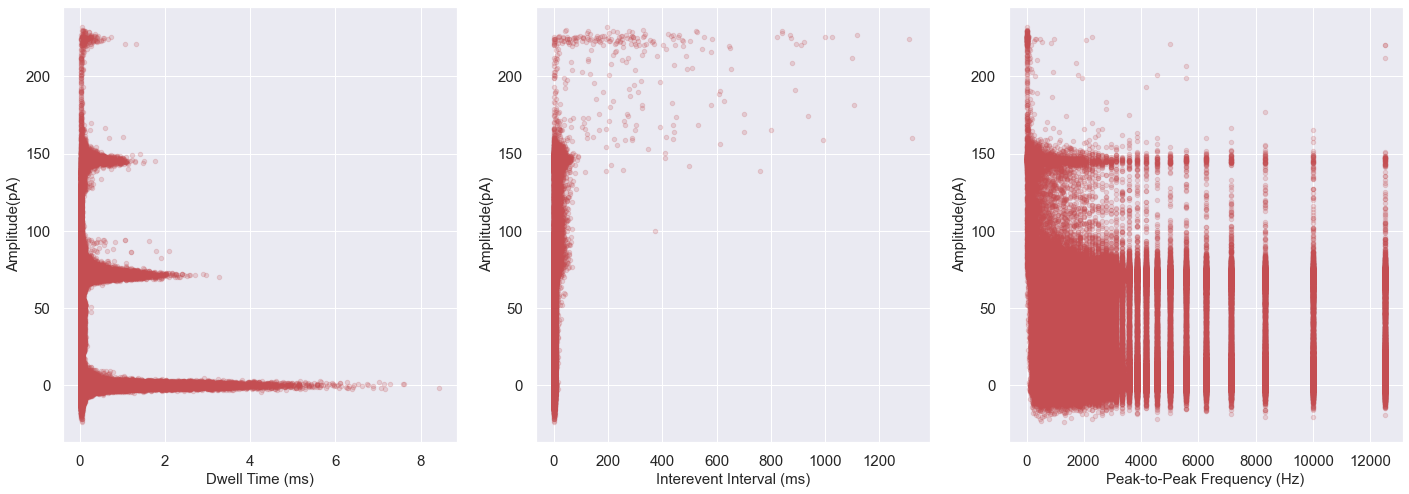

In [810]:
# Cosmetics
print('#'*100)
print()
print('Scatter plot of all the numeric features')
print()
print('#'*100)

features = ['Dwell Time (ms)','Interevent Interval (ms)', 'Peak-to-Peak Frequency (Hz)']

# Figure cosmetics
fig, axs = plt.subplots(1,len(features), figsize=(24,8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=.2)

# looping through all the feature 
for f, i in zip(features, range(len(features))):
    
    axs[i].scatter(df[f],df['Amplitude (pA)'], s =20, c = 'r', alpha = 0.2)
    axs[i].set_xlabel(f,fontsize=15)
    axs[i].set_ylabel('Amplitude(pA)',fontsize=15)
    axs[i].tick_params(axis='x', labelsize= 15)
    axs[i].tick_params(axis='y', labelsize= 15)

####################################################################################################

Histogram of all the important numeric features

####################################################################################################


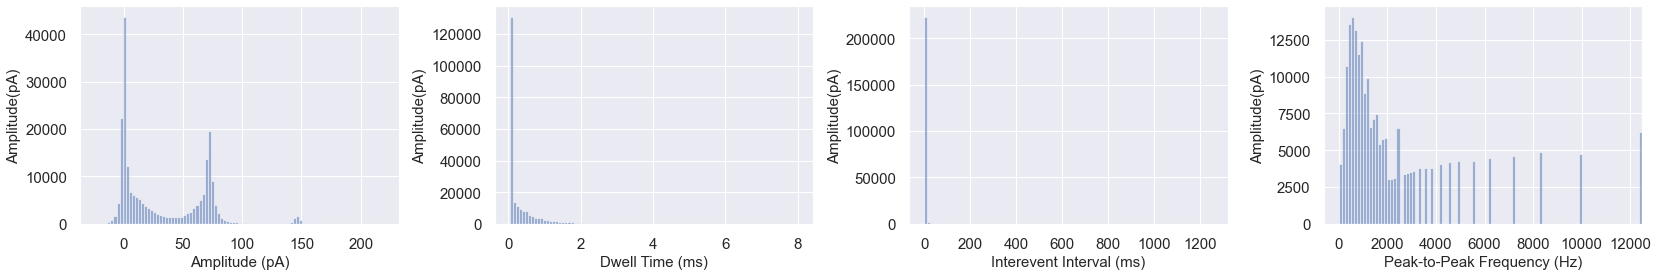

In [811]:
# Cosmetics
print('#'*100)
print()
print('Histogram of all the important numeric features')
print()
print('#'*100)

features = ['Amplitude (pA)','Dwell Time (ms)','Interevent Interval (ms)', 'Peak-to-Peak Frequency (Hz)']

# Figure cosmetics
fig, axs = plt.subplots(1,len(features), figsize=(28,4), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=.3)

# looping through all the feature 
for f, i in zip(features, range(len(features))):
    
    axs[i].hist(df[f], bins = 100, alpha = 0.5)
    axs[i].set_xlim(df[f].min() - (df[f].max()-df[f].min())/20,df[f].max())
    axs[i].set_xlabel(f,fontsize=15)
    axs[i].set_ylabel('Amplitude(pA)',fontsize=15)
    axs[i].tick_params(axis='x', labelsize= 15)
    axs[i].tick_params(axis='y', labelsize= 15)
    

####################################################################################################

Scatter plot of all the numeric features

####################################################################################################


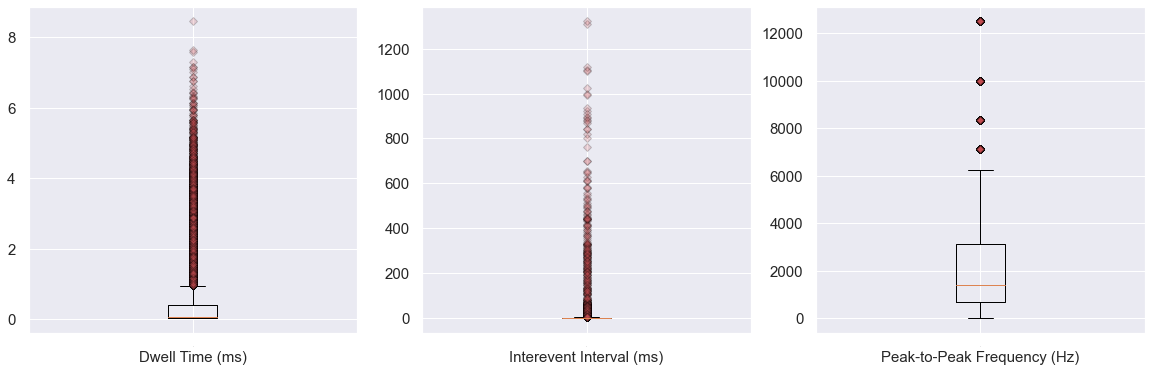

In [812]:
# Cosmetics
print('#'*100)
print()
print('Scatter plot of all the numeric features')
print()
print('#'*100)

features = features = ['Dwell Time (ms)','Interevent Interval (ms)', 'Peak-to-Peak Frequency (Hz)']

# Figure cosmetics
fig, axs = plt.subplots(1,len(features), figsize=(20,6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=.2)
green_diamond = dict(markerfacecolor='r', marker='D', alpha = 0.2)

# looping through all the feature 
for f, i in zip(features, range(len(features))):
    axs[i].boxplot(df[f],flierprops=green_diamond, labels = None)
    axs[i].set_xlabel(f,fontsize=15)
    axs[i].tick_params(axis='x', labelsize= 0) 
    axs[i].tick_params(axis='y', labelsize= 15)
    
#ax = sns.boxplot(data=df[features], orient="h", palette="Set2") command to plot all the boxplot in one plot
#box_plt= plt.boxplot(df[features], labels=features)

<AxesSubplot:xlabel='Level', ylabel='count'>

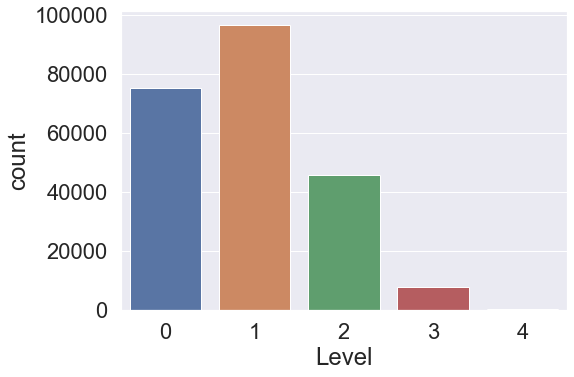

In [813]:
sns.countplot(data = df, x  =df['Level'])

In [814]:
df.head(1)

,Trace,Search,Level,State,Event Start Time (ms),Event End Time (ms),Amplitude (pA),Amp S.D. (pA),Dwell Time (ms),Peak-to-Peak Frequency (Hz),Interevent Interval (ms)
2,1,1,1,AB,1.5,1.56,9.592655,0.0,0.06,781.25,1.28


# Feature Engineering

## ECD calculation of single events (Electron Charge Deficit calc)

 $$ ecd = \int_{0}^{D_T} \Delta I_{B}(t)dt$$
 $$ $$
        $$=  \Delta I_{avg}.T_{R} $$
        
  
 $$ ecd  = Electron Charge Deficit $$
 $$ {D_T} = Dwell Time $$
 $$ I_{B} = Blockage Current $$

In [815]:
df['ECD'] = df['Amplitude (pA)']*df['Dwell Time (ms)']

In [816]:
df.head(2)

,Trace,Search,Level,State,Event Start Time (ms),Event End Time (ms),Amplitude (pA),Amp S.D. (pA),Dwell Time (ms),Peak-to-Peak Frequency (Hz),Interevent Interval (ms),ECD
2,1,1,1,AB,1.50,1.56,9.592655,0.000000,0.06,781.250000,1.28,0.575559
3,1,1,0,A,1.56,3.42,0.673338,6.202096,1.86,769.230774,1.30,1.252409


In [817]:
#df.drop(df[df['Level'] == 3].index, inplace = True)
#df.drop(df[df['Level'] == 4].index, inplace = True)

In [818]:
#df.drop(df[df['Level'] == 4].index, inplace = True)

In [819]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225825 entries, 2 to 225829
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Trace                        225825 non-null  int64  
 1   Search                       225825 non-null  int64  
 2   Level                        225825 non-null  int64  
 3   State                        225825 non-null  object 
 4   Event Start Time (ms)        225825 non-null  float64
 5   Event End Time (ms)          225825 non-null  float64
 6   Amplitude (pA)               225825 non-null  float64
 7   Amp S.D. (pA)                225825 non-null  float64
 8   Dwell Time (ms)              225825 non-null  float64
 9   Peak-to-Peak Frequency (Hz)  225825 non-null  float64
 10  Interevent Interval (ms)     225825 non-null  float64
 11  ECD                          225825 non-null  float64
dtypes: float64(8), int64(3), object(1)
memory usage: 30.5+ MB


<AxesSubplot:xlabel='Level', ylabel='count'>

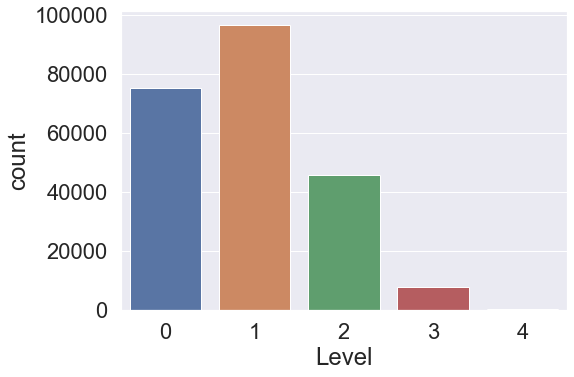

In [820]:
sns.countplot(data = df, x  =df['Level'])

### Looking at the above barplot of 'Levels,' which is the dataset's taget variable, it appears that the dataset has an imbalance class, which would generate a bias while developing the model by shadowing the minor class (level 3 and level 4). To solve this issue, I will approach this dataset in 3 steps:

#### 1. During the first stage of model development and metric evaluation, I will use the data as is.

#### 2. Following that, I will eliminate levels 3 and 4, construct the model, and compare their metrics.

#### 3. Finally, I'll restore all of the levels and use inbult libraries to correct for data imbalance.

# Spliting the data

In [821]:
df.columns

Index(['Trace', 'Search', 'Level', 'State', 'Event Start Time (ms)',
       'Event End Time (ms)', 'Amplitude (pA)', 'Amp S.D. (pA)',
       'Dwell Time (ms)', 'Peak-to-Peak Frequency (Hz)',
       'Interevent Interval (ms)', 'ECD'],
      dtype='object')

In [822]:
X = df[['Amplitude (pA)','Amp S.D. (pA)','Dwell Time (ms)','Interevent Interval (ms)', 'Peak-to-Peak Frequency (Hz)', 'ECD']]

y = df['Level']

# Train - Test Split

In [823]:
def train_test_split_dataset (X_df, y_df, test_size, random_state):
    Xtrain, Xtest, ytrain, ytest = train_test_split(X_df, y_df, test_size=test_size, random_state= random_state)
    return Xtrain, Xtest, ytrain, ytest

In [824]:
train_test_split_dataset(X, y, 0.25, 42)

(        Amplitude (pA)  Amp S.D. (pA)  Dwell Time (ms)  \
 141566       -0.626000       6.113968             0.70   
 145596       85.047691      12.501037             0.14   
 52868         1.715468       6.279294             0.76   
 195662       -0.097829       6.190616             0.48   
 47231        -1.319365       7.218639             0.76   
 ...                ...            ...              ...   
 119884      143.081268       7.901048             0.14   
 103699        2.494142       7.236169             0.78   
 131937       66.951805       4.362342             0.12   
 146872       -0.752144       6.349696             0.42   
 121963       72.397820       6.054509             0.96   
 
         Interevent Interval (ms)  Peak-to-Peak Frequency (Hz)        ECD  
 141566                      0.24                  4166.666504  -0.438200  
 145596                      3.18                   314.465424  11.906677  
 52868                       0.30                  3333.333252

In [825]:
# Select Categorical and numeric features

#categorical_col = Xtrain.select_dtypes(include='object').columns # not categorial columns in the dataframe

numeric_col = Xtrain.select_dtypes(include='number').columns

In [826]:
numeric_col

Index(['Amplitude (pA)', 'Amp S.D. (pA)', 'Dwell Time (ms)',
       'Interevent Interval (ms)', 'Peak-to-Peak Frequency (Hz)', 'ECD'],
      dtype='object')

In [827]:
# Instantiate the function OneHotEncode
ohe = OneHotEncoder()

In [828]:
# Instantiate the function RobustScaler
scaler = RobustScaler()
scaler_min_max = MinMaxScaler()
Scaler_standard = StandardScaler()

In [829]:
# Define transformers
transformers = [
                ('Scaler_standard', StandardScaler(), numeric_col)]

#('ohe', OneHotEncoder(drop='first'), categorical_col)

In [830]:
# Define column transformer
column_transformer = ColumnTransformer(
    transformers=transformers, remainder='drop')

In [831]:
# Fit and transform the column transformer ONLY on Xtrain
Xtrain_tf = column_transformer.fit_transform(Xtrain)

# Transform Xtest
Xtest_tf = column_transformer.transform(Xtest)

In [832]:
column_transformer

ColumnTransformer(transformers=[('Scaler_standard', StandardScaler(),
                                 Index(['Amplitude (pA)', 'Amp S.D. (pA)', 'Dwell Time (ms)',
       'Interevent Interval (ms)', 'Peak-to-Peak Frequency (Hz)', 'ECD'],
      dtype='object'))])

In [833]:
Xtrain_tf = pd.DataFrame(Xtrain_tf, columns=['Amplitude_(pA)','Amp_SD_(pA)','Dwell_Time_(ms)','Interevent_Interval_(ms)', 'Peak-to-Peak Frequency (Hz)', 'ECD']) #columns=column_transformer.get_feature_names_out()) the .get_feature_names_out() present only in sklear 1.0
Xtrain_tf

,Amplitude_(pA),Amp_SD_(pA),Dwell_Time_(ms),Interevent_Interval_(ms),Peak-to-Peak Frequency (Hz),ECD
0,-0.913883,0.831805,0.660892,-0.107585,0.620528,-0.434227
1,1.400452,2.639124,-0.353373,0.115777,-0.778798,0.468416
2,-0.850632,0.878586,0.769563,-0.103027,0.317816,-0.306857
3,-0.899616,0.853493,0.262430,-0.066559,-0.427319,-0.405619
4,-0.932613,1.144388,0.769563,0.039804,-0.726399,-0.475503
...,...,...,...,...,...,...
169363,2.968135,1.337486,-0.353373,0.766110,-0.862087,1.062484
169364,-0.829598,1.149349,0.805787,-0.063520,-0.450037,-0.259938
169365,0.911621,0.336155,-0.389597,0.368009,-0.837144,0.185266
169366,-0.917291,0.898508,0.153759,-0.083273,-0.244362,-0.425284


In [834]:
Xtest_tf = pd.DataFrame(Xtest_tf, columns=['Amplitude_(pA)','Amp_SD_(pA)','Dwell_Time_(ms)','Interevent_Interval_(ms)', 'Peak-to-Peak Frequency (Hz)', 'ECD']) #columns=column_transformer.get_feature_names_out()) the .get_feature_names_out() present only in sklear 1.0
Xtest_tf

,Amplitude_(pA),Amp_SD_(pA),Dwell_Time_(ms),Interevent_Interval_(ms),Peak-to-Peak Frequency (Hz),ECD
0,-0.770192,-0.898237,-0.534492,-0.103027,0.317816,-0.388459
1,-0.850317,1.061480,0.081312,-0.087832,-0.166522,-0.354197
2,0.869884,-0.898237,-0.534492,-0.087832,-0.166522,-0.210887
3,1.032269,-0.898237,-0.534492,0.036765,-0.723284,-0.193306
4,-0.958015,1.631612,-0.172254,-0.116702,2.134084,-0.441841
...,...,...,...,...,...,...
56452,-0.913962,-0.898237,-0.534492,-0.101507,0.242139,-0.404025
56453,1.042489,1.227842,-0.317149,-0.042248,-0.562798,0.437760
56454,1.067773,-0.898237,-0.534492,-0.042248,-0.562798,-0.189462
56455,-0.414449,-0.898237,-0.534492,-0.089351,-0.136251,-0.349943


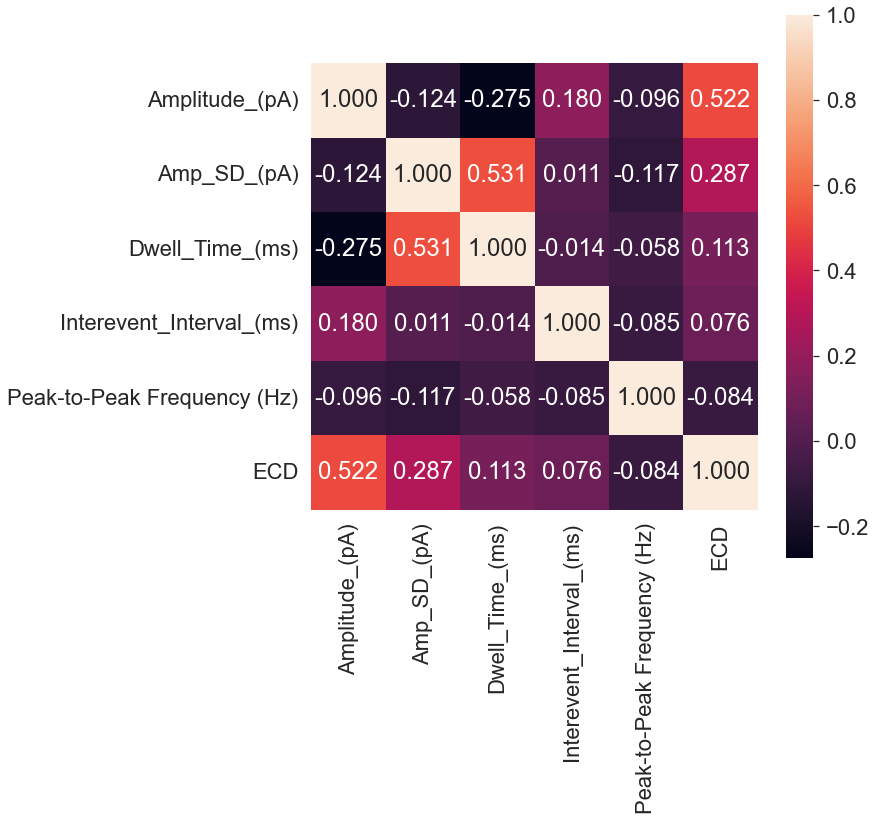

In [835]:
conf_marix = Xtrain_tf.corr()
fig = plt.figure(figsize=(10,10))
sns.heatmap(conf_marix,annot = True, square = True, fmt = '.3f')
plt.show()

# Train Model

#### grid search
#### ROC
#### Different Metric
#### Stratified split
#### make a validation dataset from your train set
#### class imbalance

In [836]:
target_names = ['class 0','class 1', 'class 2','class 3','class 4']

In [837]:
def ensemble_models(xtraining, ytraining, xtesting,ytesting,target_names):
    """This function evaluates multiple classifier models on a given dataset 
        and generates a evaluation report for all the models and based on that, one 
        can choose best model for further optimizing the model
        *******************************************************************************
        Inputs required:
            1. xtraining
            2. xtesting
            3. ytraining
            4. ytesting
            5. target_name : this is input list with all the target names
                eg: target_name = ['class 0', 'class 1', 'class 2','class 3','class 4']
        *******************************************************************************        
        Output:
            1. Classification report
                eg:     precision    recall  f1-score   support

             class 0       1.00      0.93      0.96     18753
             class 1       0.85      0.99      0.91     24273
             class 2       0.96      0.76      0.84     11399
             class 3       0.90      0.83      0.86      1960
             class 4       0.83      0.90      0.87        72

            accuracy                           0.92     56457
           macro avg       0.91      0.88      0.89     56457
        weighted avg       0.92      0.92      0.91     56457
        
            2. Dataframe with crossvalidate score value for all the models
            3. Box plot of Validation scores
        """
    

    models = [] #paired values in list
    models.append(('LR', LogisticRegression(solver='newton-cg', multi_class='ovr', n_jobs= -1 )))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('QDA',QuadraticDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier(n_jobs=-1)))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('XGB',xgb.dask.XGBClassifier(tree_method = 'gpu_hist',verbosity=1,use_label_encoder=False,eval_metric='mlogloss')))
    #models.append(('CatBC',CatBoostClassifier(task_type="GPU")))
    #models.append(('RFC',RandomForestClassifier(n_estimators= 1000,min_samples_split= 100, min_samples_leaf= 10, n_jobs=-1)))
    models.append(('NB', GaussianNB()))
    
    # building a font dict so that it can be used for plotting boxplot
    font = {'family': 'serif',
            'color':  'darkred',
            'weight': 'normal',
            'size': 16,
            }

    #scoring = precision_macro, recall_macro, accuracy, f1_macro, precision_micro
    
    #evaluate each model in turn:
    results = []
    names = []
    scores = pd.DataFrame()
    for name, model in models:
        kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
        cv_results = cross_val_score(model, xtraining, ytraining, cv=kfold, scoring='recall_micro')
        clf = model.fit(xtraining, ytraining)
        yprediction = clf.predict(xtesting)
        results.append(cv_results)
        names.append(name)

        print('#'*30)
        print(type(model).__name__)
        print()
        print(classification_report(ytesting, yprediction, target_names=target_names))
        #stat = {'val_score':round(cv_results.mean()*100,1), 'val_std':round(cv_results.std()*100,2)}
        #print(f'{name}:',round(cv_results.mean()*100,1),"\u00B1",round(cv_results.std()*100,2),'%')
        score = {'Validation_Score %':round(cv_results.mean()*100,1), 'error':round(cv_results.std()*100,2)}
        scores = scores.append(score,ignore_index = True)
    scores['model'] = names
    scores.set_index('model', inplace=True)
    print('#'*30)
    print(scores)
    
    plt.boxplot(results, labels=names)
    plt.title('Algorithm comparison', fontdict=font)
    plt.xlabel('Models', fontdict=font)
    plt.ylabel('Validation_score', fontdict=font)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.show()


        

##############################
LogisticRegression

              precision    recall  f1-score   support

     class 0       1.00      0.93      0.96     18753
     class 1       0.85      0.99      0.91     24273
     class 2       0.94      0.74      0.83     11399
     class 3       0.89      0.64      0.75      1960
     class 4       1.00      0.72      0.84        72

    accuracy                           0.91     56457
   macro avg       0.93      0.81      0.86     56457
weighted avg       0.92      0.91      0.91     56457

##############################
LinearDiscriminantAnalysis

              precision    recall  f1-score   support

     class 0       0.99      0.91      0.95     18753
     class 1       0.83      0.99      0.90     24273
     class 2       0.99      0.72      0.83     11399
     class 3       0.87      0.83      0.85      1960
     class 4       1.00      0.67      0.80        72

    accuracy                           0.91     56457
   macro avg       0.

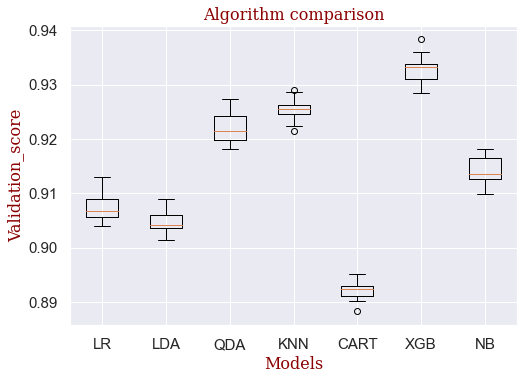

In [838]:
ensemble_models(Xtrain_tf,ytrain,Xtest_tf,ytest,target_names)

### By looking at the classification report and accuracy scores, I chose to work with XGBoostclassifier as it perfomed well compared to other models.

In [839]:
# Make prediction on validated dataset
model = xgb.dask.XGBClassifier(tree_method = 'gpu_hist',verbosity=1,use_label_encoder=False,eval_metric='mlogloss')
model.fit(Xtrain_tf, ytrain)
prediction = model.predict(Xtest_tf)

In [840]:
def Confusion_Matrix_ (Test, Predicted, Class, model):
    
    """This function will generate a confusion matrix heat map with and without normalized count.
        The function will take 3 input arguments:
        1. Test: can be ytest or ytrain
        2. Predicted: can be ytest_predictes or ytrain_predicted
        3. Class: this is the list/vector of ytrain or ytest, it is just used 
            to automate the xtick and ytick labels
        4. model: str input of the model used
            eg: 'LR' for Logistic Regression."""
    #from matplotlib.pyplot import subplots, show
    
    fig, axs = plt.subplots(1,2, figsize=(24,8), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .1, wspace=.2)
    Normalize = [None,'true']
    sns.set(font_scale=2)
    for norm, i in zip(Normalize, range(len(Normalize))):
        corr_map = confusion_matrix(Test, Predicted, normalize=norm)
        sns.heatmap(corr_map,
                    annot=True,
                    cmap='BuPu',
                    ax=axs[i],
                    annot_kws={"size":20}
                    )
        
        axs[i].set_ylabel("True class",fontsize=25)
        axs[i].set_xlabel("Predicted class",fontsize=25)
        axs[i].set_title(f'Confusion_Martix - {model}',fontsize=20)
        axs[i].set_xticklabels(np.unique(Class),fontsize=20)
        axs[i].set_yticklabels(np.unique(Class),fontsize=20)
    return plt.show()

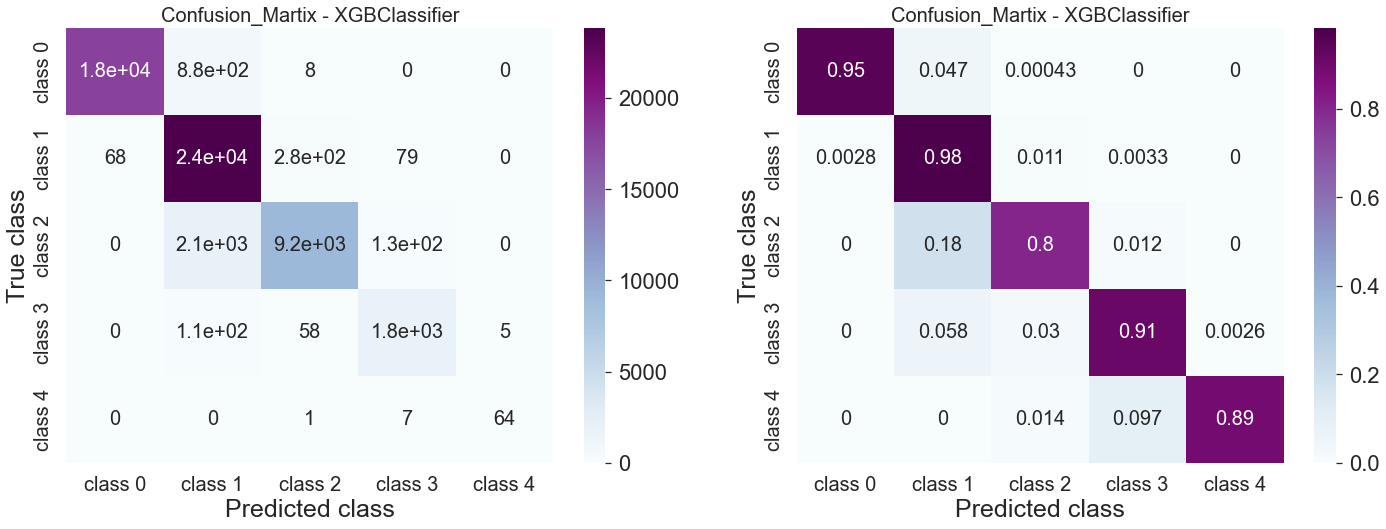

In [841]:
Confusion_Matrix_(ytest, prediction,target_names,'XGBClassifier')

### This will not work well for the above imbalanced dataset as the performance on the majority class will overshadow the minority class.

# _____________________________________________________________

### Drop level 3 and level 4 from the dataset and compare the evaluation metric before and after the drop to see if the model shows any bias towards majority class

In [842]:
df_model_1 = df.copy(deep=True)

In [843]:
df_model_1.drop(df_model_1[df_model_1['Level'] == 3].index, inplace = True)
df_model_1.drop(df_model_1[df_model_1['Level'] == 4].index, inplace = True)

In [844]:
df_model_1.shape

(217775, 12)

In [845]:
X_model_1 = df_model_1[['Amplitude (pA)','Amp S.D. (pA)','Dwell Time (ms)','Interevent Interval (ms)', 'Peak-to-Peak Frequency (Hz)', 'ECD']]

y_model_1 = df_model_1['Level']

In [846]:
Xtrain_, Xtest_, ytrain_, ytest_ = train_test_split(X_model_1, y_model_1, test_size=0.25, random_state= 42)

In [847]:
# Fit and transform the column transformer ONLY on Xtrain
Xtrain_model1_tf = column_transformer.fit_transform(Xtrain_)

# Transform Xtest
Xtest_model1_tf = column_transformer.transform(Xtest_)

In [848]:
Xtrain_model1_tf = pd.DataFrame(Xtrain_model1_tf, columns=['Amplitude_(pA)','Amp_SD_(pA)','Dwell_Time_(ms)','Interevent_Interval_(ms)', 'Peak-to-Peak Frequency (Hz)', 'ECD']) #columns=column_transformer.get_feature_names_out()) the .get_feature_names_out() present only in sklear 1.0
#Xtrain_tf
Xtest_model1_tf = pd.DataFrame(Xtest_model1_tf, columns=['Amplitude_(pA)','Amp_SD_(pA)','Dwell_Time_(ms)','Interevent_Interval_(ms)', 'Peak-to-Peak Frequency (Hz)', 'ECD']) #columns=column_transformer.get_feature_names_out()) the .get_feature_names_out() present only in sklear 1.0
#Xtest_tf

In [849]:
target_names_model1 = ['class 0','class 1', 'class 2']

##############################
LogisticRegression

              precision    recall  f1-score   support

     class 0       1.00      0.93      0.96     18841
     class 1       0.87      0.98      0.92     24110
     class 2       0.96      0.79      0.87     11493

    accuracy                           0.92     54444
   macro avg       0.94      0.90      0.92     54444
weighted avg       0.93      0.92      0.92     54444

##############################
LinearDiscriminantAnalysis

              precision    recall  f1-score   support

     class 0       0.99      0.91      0.95     18841
     class 1       0.84      0.99      0.91     24110
     class 2       0.99      0.75      0.85     11493

    accuracy                           0.91     54444
   macro avg       0.94      0.88      0.90     54444
weighted avg       0.92      0.91      0.91     54444

##############################
QuadraticDiscriminantAnalysis

              precision    recall  f1-score   support

     class 

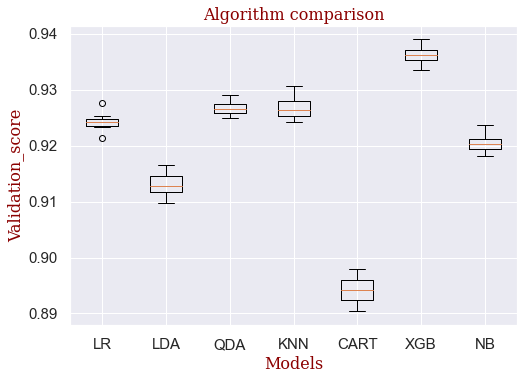

In [850]:
ensemble_models(Xtrain_model1_tf,ytrain_,Xtest_model1_tf,ytest_,target_names_model1)

In [851]:
# Make prediction on validated dataset
model_1 = xgb.dask.XGBClassifier(tree_method = 'gpu_hist',verbosity=1,use_label_encoder=False,eval_metric='mlogloss')
model_1.fit(Xtrain_model1_tf,ytrain_)
prediction_ = model_1.predict(Xtest_model1_tf)

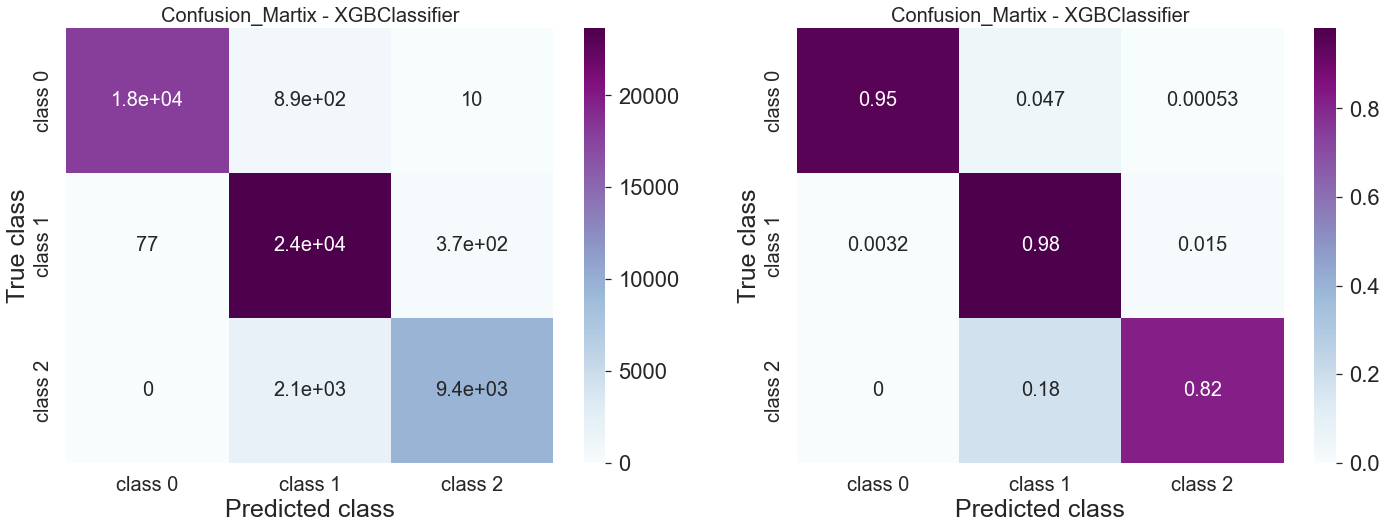

In [852]:
Confusion_Matrix_(ytest_, prediction_, target_names_model1,'XGBClassifier')

### Looking at the above report it seems the model imporoved only by 1% after removing level 3 and level 4

# _______________________________________________________________

### Correction to imbalance data

In [853]:
ros = RandomOverSampler(random_state=10, sampling_strategy="auto")

X_ros, y_ros = ros.fit_resample(X, y)

print(f'unique samples in each class (oversampled): \n{y_ros.value_counts()}')

unique samples in each class (oversampled): 
1    96613
0    96613
2    96613
3    96613
4    96613
Name: Level, dtype: int64


In [854]:
Xtrain_ros, Xtest_ros, ytrain_ros, ytest_ros = train_test_split(X_ros, y_ros, test_size=0.25, random_state= 42)

In [855]:
# Fit and transform the column transformer ONLY on Xtrain
Xtrain_ros_tf = column_transformer.fit_transform(Xtrain_ros)

# Transform Xtest
Xtest_ros_tf = column_transformer.transform(Xtest_ros)

In [856]:
Xtrain_ros_tf = pd.DataFrame(Xtrain_ros_tf, columns=['Amplitude_(pA)','Amp_SD_(pA)','Dwell_Time_(ms)','Interevent_Interval_(ms)', 'Peak-to-Peak Frequency (Hz)', 'ECD']) #columns=column_transformer.get_feature_names_out()) the .get_feature_names_out() present only in sklear 1.0
#Xtrain_tf
Xtest_ros_tf = pd.DataFrame(Xtest_ros_tf, columns=['Amplitude_(pA)','Amp_SD_(pA)','Dwell_Time_(ms)','Interevent_Interval_(ms)', 'Peak-to-Peak Frequency (Hz)', 'ECD']) #columns=column_transformer.get_feature_names_out()) the .get_feature_names_out() present only in sklear 1.0
#Xtest_tf

In [857]:
target_names_ros = ['class 0','class 1', 'class 2','class 3','class 4']

##############################
LogisticRegression

              precision    recall  f1-score   support

     class 0       1.00      0.93      0.96     24319
     class 1       0.75      0.98      0.85     24105
     class 2       0.88      0.71      0.79     24087
     class 3       0.85      0.85      0.85     24025
     class 4       0.99      0.95      0.97     24231

    accuracy                           0.88    120767
   macro avg       0.89      0.88      0.88    120767
weighted avg       0.89      0.88      0.88    120767

##############################
LinearDiscriminantAnalysis

              precision    recall  f1-score   support

     class 0       1.00      0.91      0.95     24319
     class 1       0.76      0.84      0.80     24105
     class 2       0.81      0.81      0.81     24087
     class 3       0.89      0.93      0.91     24025
     class 4       1.00      0.93      0.96     24231

    accuracy                           0.89    120767
   macro avg       0.

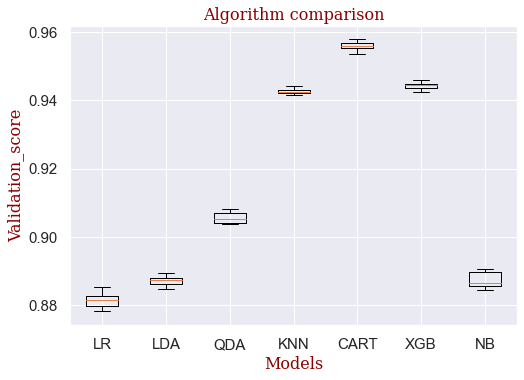

In [858]:
ensemble_models(Xtrain_ros_tf, ytrain_ros, Xtest_ros_tf, ytest_ros, target_names_ros)

In [859]:
# Make prediction on validated dataset
model_ros = xgb.dask.XGBClassifier(tree_method = 'gpu_hist',verbosity=1,use_label_encoder=False,eval_metric='mlogloss')
model_ros.fit(Xtrain_ros_tf, ytrain_ros)
prediction_ros = model_ros.predict(Xtest_ros_tf)

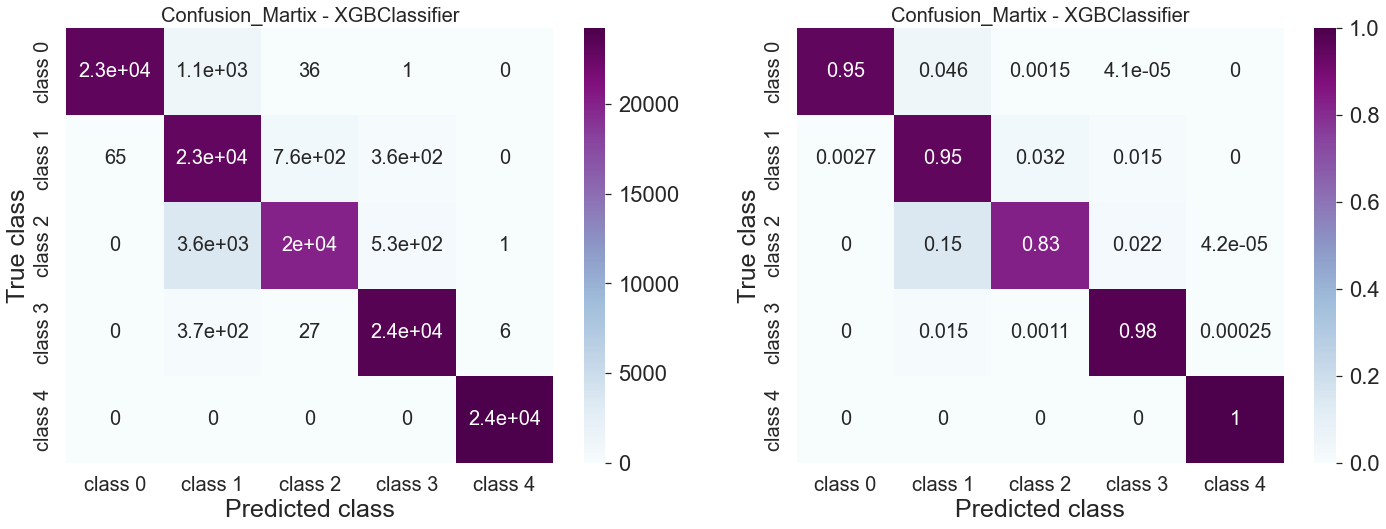

In [860]:
Confusion_Matrix_(ytest_ros, prediction_ros, target_names_ros ,'XGBClassifier')

In [861]:
#DecisionTreeClassifier
# Make prediction on validated dataset
model_ros_DCT = DecisionTreeClassifier()
model_ros_DCT.fit(Xtrain_ros_tf, ytrain_ros)
prediction_DCT_ros = model_ros_DCT.predict(Xtest_ros_tf)

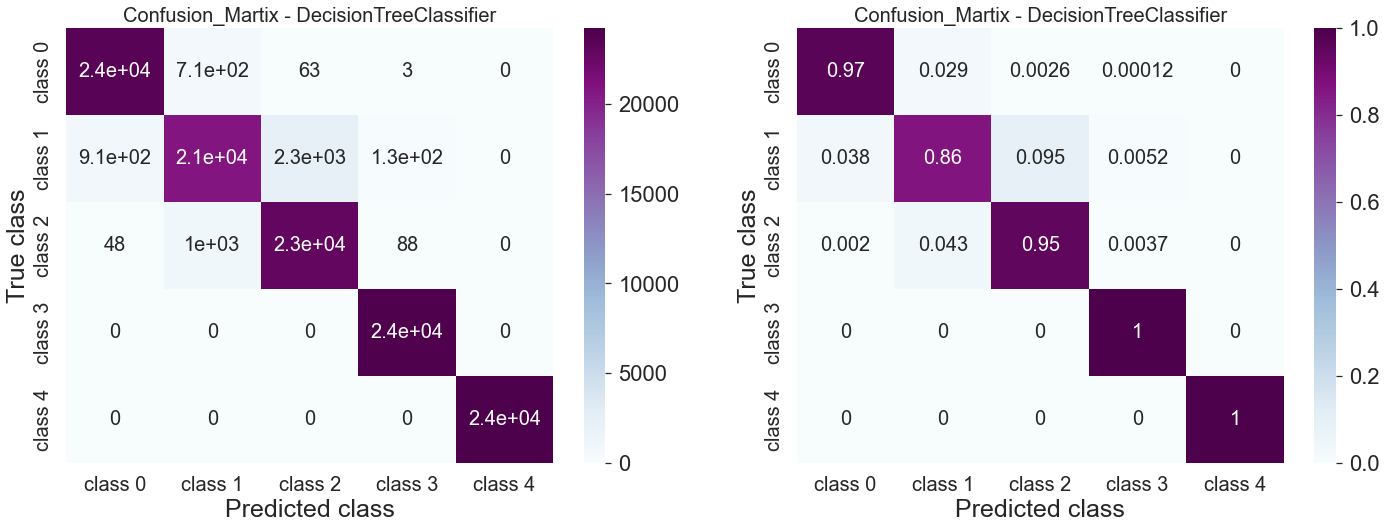

In [862]:
Confusion_Matrix_(ytest_ros, prediction_DCT_ros, target_names_ros ,'DecisionTreeClassifier')

### calculating feature importance using XGBclassifier

<AxesSubplot:xlabel='importance', ylabel='feature'>

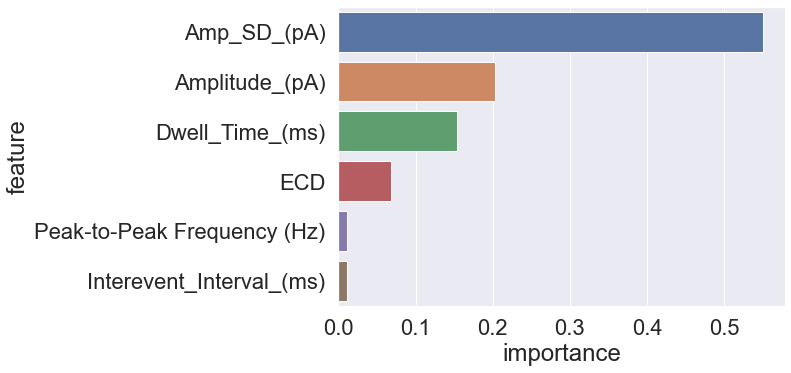

In [863]:
feature_importance_dict = {'importance': model_ros.feature_importances_, 'feature': Xtrain_ros_tf.columns}
importance = pd.DataFrame(data=feature_importance_dict).sort_values('importance', ascending=False)
sns.barplot(data= importance, x = 'importance', y = 'feature' )

In [864]:
importance

,importance,feature
1,0.550790,Amp_SD_(pA)
0,0.203368,Amplitude_(pA)
2,0.154248,Dwell_Time_(ms)
5,0.068112,ECD
4,0.011748,Peak-to-Peak Frequency (Hz)
3,0.011733,Interevent_Interval_(ms)


#### The feature importance plot generated during model testing (XGBclassifier) indicates the relative relevance of all six features in event classification, and it appears that ['Amplitude (pA),' 'Amp SD (pA),' 'Dwell Time (ms),' and 'ECD'] play an essential role. So I'm going to re-run the model with those critical features.

In [865]:
# removing 'Peak-to-Peak Frequency (Hz)' and 'Interevent_Interval_(ms)' features from the dataframe
Xtrain_ros_tf = Xtrain_ros_tf.drop(labels= ['Interevent_Interval_(ms)', 'Peak-to-Peak Frequency (Hz)'],axis=1)
Xtest_ros_tf = Xtest_ros_tf.drop(labels= ['Interevent_Interval_(ms)', 'Peak-to-Peak Frequency (Hz)'],axis=1)

In [866]:
# Make prediction on validated dataset
model_ros_FI = xgb.dask.XGBClassifier(tree_method = 'gpu_hist',verbosity=1,use_label_encoder=False,eval_metric='mlogloss')
model_ros_FI.fit(Xtrain_ros_tf, ytrain_ros)
prediction_ros_FI = model_ros_FI.predict(Xtest_ros_tf)

In [867]:
print(f"""The train accuracy is: {round(model_ros_FI.score(Xtrain_ros_tf, ytrain_ros),3)}
The test accuracy is: {round(model_ros_FI.score(Xtest_ros_tf,ytest_ros),3)}""")

The train accuracy is: 0.926
The test accuracy is: 0.925


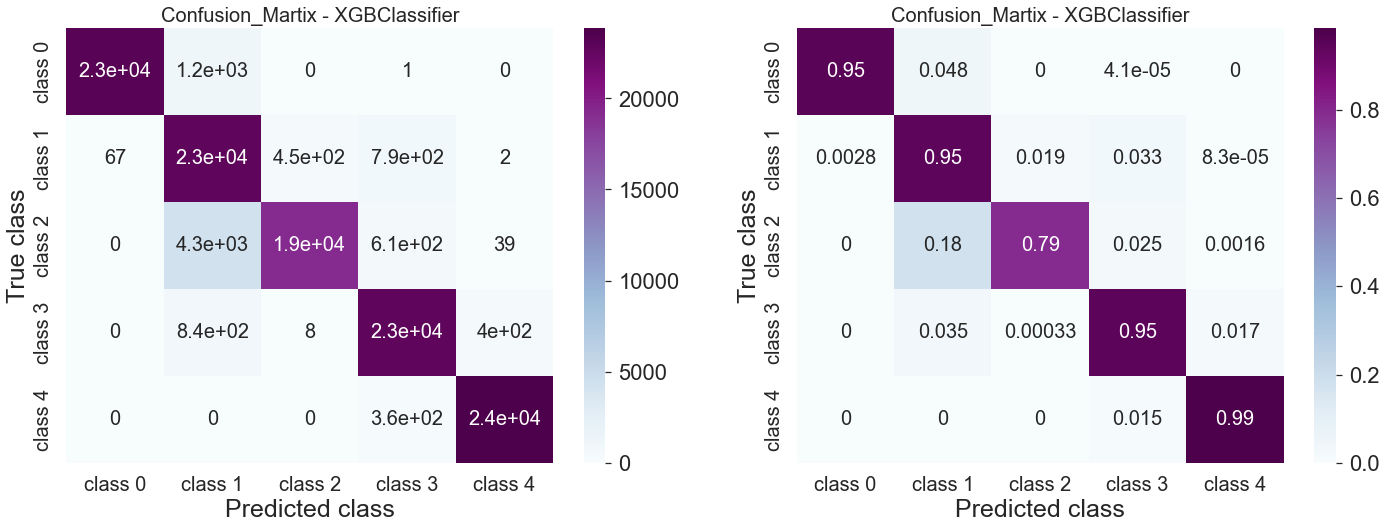

In [868]:
Confusion_Matrix_(ytest_ros, prediction_ros_FI, target_names_ros ,'XGBClassifier')

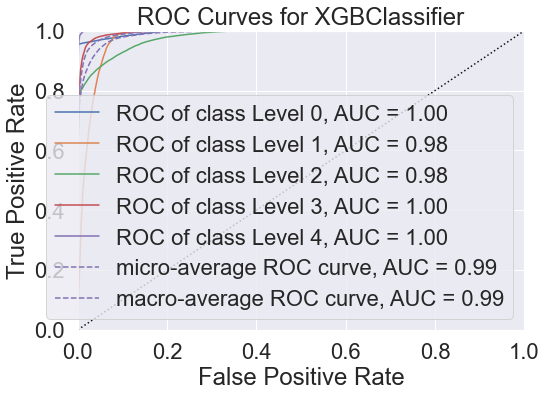

AttributeError: 'XGBClassifier' object has no attribute 'binary'

AttributeError: 'XGBClassifier' object has no attribute 'binary'

AttributeError: 'XGBClassifier' object has no attribute 'binary'

In [792]:

from yellowbrick.classifier.rocauc import roc_auc
roc_auc(model_ros_FI, Xtrain_ros_tf, ytrain_ros,Xtest_ros_tf, ytest_ros, 
        classes=['Level 0', 'Level 1','Level 2','Level 3','Level 4'])

In [793]:
import yellowbrick.classifier 
from yellowbrick.classifier import ROCAUC

def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model,micro=False,macro = False, encoder={0: 'Level 0', 
                                        1: 'Level 1', 
                                        2: 'Level 2',
                                        3: 'Level 3',
                                        4: 'Level 4'})
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

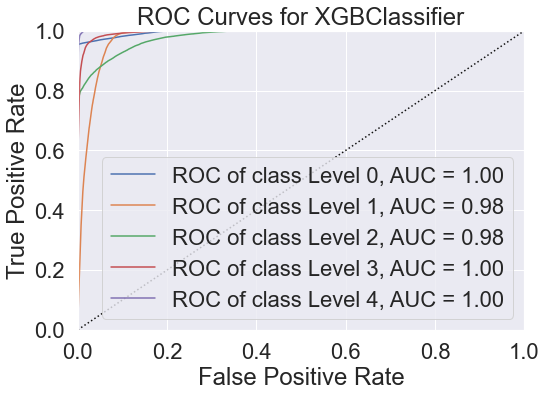

AttributeError: 'XGBClassifier' object has no attribute 'binary'

AttributeError: 'XGBClassifier' object has no attribute 'binary'

AttributeError: 'XGBClassifier' object has no attribute 'binary'

In [794]:
plot_ROC_curve(model_ros_FI, Xtrain_ros_tf, ytrain_ros,Xtest_ros_tf, ytest_ros )

In [269]:
%%time
model_pipeline = Pipeline(steps=[('model1',RandomForestClassifier(n_estimators= 1000,min_samples_split= 100, min_samples_leaf= 10 ))])

Wall time: 0 ns


In [271]:
%%time
model_pipeline.fit(Xtrain_tf, ytrain)

Wall time: 2min 16s


Pipeline(steps=[('model1',
                 RandomForestClassifier(min_samples_leaf=10,
                                        min_samples_split=100,
                                        n_estimators=1000))])

In [272]:
%%time
print(f"""The train accuracy of pipeline 1 is: {round(model_pipeline.score(Xtrain_tf,ytrain),3)}
The test accuracy of pipeline 1 is: {round(model_pipeline.score(Xtest_tf,ytest),3)}""")

The train accuracy of pipeline 1 is: 0.939
The test accuracy of pipeline 1 is: 0.938
Wall time: 18.2 s


In [207]:
%%time
rf1 = RandomForestClassifier(n_estimators= 1000,min_samples_split= 100, min_samples_leaf= 2 ).fit(Xtrain_tf, ytrain)

In [208]:
rf1.score(Xtrain_tf, ytrain)

0.9390930074511269

In [209]:
rf1.score(Xtest_tf, ytest)

0.9378076555726985

##### GridSearch for RandomForestClassifier

In [300]:
model_pipeline

Pipeline(steps=[('model1',
                 RandomForestClassifier(min_samples_leaf=10,
                                        min_samples_split=100,
                                        n_estimators=1000))])

In [301]:
feature_importance_dict = {'importance': model_pipeline.named_steps["model1"].feature_importances_, 'feature': Xtrain_tf.columns}

In [302]:
feature_importance_dict

{'importance': array([0.2666895 , 0.25282082, 0.24136561, 0.0123547 , 0.01299137,
        0.213778  ]),
 'feature': Index(['Amplitude_(pA)', 'Amp_SD_(pA)', 'Dwell_Time_(ms)',
        'Interevent_Interval_(ms)', 'Peak-to-Peak Frequency (Hz)', 'ECD'],
       dtype='object')}

In [296]:
# feature_importance_dict = {'importance': rf1.feature_importances_, 'feature': Xtrain_tf.columns}
#ypred = rf1.predict(Xtest_tf)

In [297]:
importance = pd.DataFrame(data=feature_importance_dict).sort_values('importance', ascending=False)

In [298]:
importance

,importance,feature
0,0.266690,Amplitude_(pA)
1,0.252821,Amp_SD_(pA)
2,0.241366,Dwell_Time_(ms)
5,0.213778,ECD
4,0.012991,Peak-to-Peak Frequency (Hz)
3,0.012355,Interevent_Interval_(ms)


<AxesSubplot:xlabel='importance', ylabel='feature'>

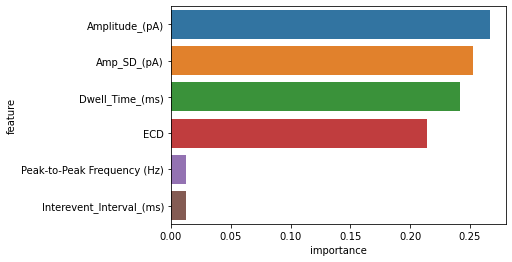

In [299]:
sns.barplot(data= importance, x = 'importance', y = 'feature' )

In [280]:
# https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

In [214]:
%%time
neigh = KNeighborsClassifier(n_neighbors= 10, weights= 'uniform', leaf_size= 30)
neigh.fit(Xtrain_tf,ytrain) 

KNeighborsClassifier(n_neighbors=10)

In [215]:
%%time
print(f"""The train accuracy of pipeline 1 is: {round(neigh.score(Xtrain_tf,ytrain),3)}
The test accuracy of pipeline 1 is: {round(neigh.score(Xtest_tf,ytest),3)}""")

The train accuracy of pipeline 1 is: 0.935
The test accuracy of pipeline 1 is: 0.931


In [216]:
%%time
clf = GradientBoostingClassifier(loss= 'deviance', n_estimators=500, learning_rate=0.1,
    max_depth=2, random_state=0).fit(Xtrain_tf,ytrain)


In [217]:
print(f"""The train accuracy of pipeline 1 is: {round(clf.score(Xtrain_tf,ytrain),3)}
The test accuracy of pipeline 1 is: {round(clf.score(Xtest_tf,ytest),3)}""")

The train accuracy of pipeline 1 is: 0.938
The test accuracy of pipeline 1 is: 0.938


In [250]:
%%time
xgb_model = xgb.XGBClassifier(n_jobs=multiprocessing.cpu_count() // 2)
clf_xg = GridSearchCV(xgb_model, {'max_depth': [2, 4, 6],
                                   'n_estimators': [50, 100, 200]}, verbose=1,
                       n_jobs=2)
clf_xg.fit(Xtrain_tf,ytrain)
print(clf_xg.best_score_)
print(clf_xg.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\Asus\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:42:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9336946848588308
{'max_depth': 2, 'n_estimators': 100}


In [322]:
%%time
clf_xg_gridsearch = xgb.XGBClassifier(max_depth = 2,n_estimators = 100, verbose=1, n_jobs=2)

In [256]:
%%time
clf_xg_gridsearch.fit(Xtrain_tf,ytrain)

[23:09:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:09:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=2, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=2,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbose=1, verbosity=None)

In [257]:
print(f"""The train accuracy of pipeline 1 is: {round(clf_xg_gridsearch.score(Xtrain_tf,ytrain),3)}
The test accuracy of pipeline 1 is: {round(clf_xg_gridsearch.score(Xtest_tf,ytest),3)}""")

The train accuracy of pipeline 1 is: 0.934
The test accuracy of pipeline 1 is: 0.934


In [37]:

#RandomForestClassifier(n_estimators= 1000,min_samples_split= 2, min_samples_leaf= 2 ))
# The train accuracy of pipeline 1 is: 0.958
# The test accuracy of pipeline 1 is: 0.925

#neigh = KNeighborsClassifier(n_neighbors= 10, weights= 'distance', leaf_size= 30)
# The train accuracy of pipeline 1 is: 1.0
# The test accuracy of pipeline 1 is: 0.92




In [89]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

# Loading the Digits dataset
digits = datasets.load_digits()

# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
y = digits.target

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]},
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
]

scores = ["precision", "recall"]

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, scoring="%s_macro" % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_["mean_test_score"]
    stds = clf.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()


# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.986 (+/-0.016) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.959 (+/-0.028) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.982 (+/-0.026) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.983 (+/-0.026) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.983 (+/-0.026) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.974 (+/-0.012) for {'C': 1, 'kernel': 'linear'}
0.974 (+/-0.012) for {'C': 10, 'kernel': 'linear'}
0.974 (+/-0.012) for {'C': 100, 'kernel': 'linear'}
0.974 (+/-0.012) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed o